# NOT YET FINISHED!

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import re
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import skimage
from scipy.ndimage import gaussian_filter
from PIL import Image, ExifTags
import exifread
import imageio
from datetime import timedelta
import pickle
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from modules import processing
from datetime import datetime
sys.path.append('../modules')
from run_handler import Campaign

In [4]:
def get_cluster_pixels(img, binary_threshold=50):
    _, mask = cv2.threshold(img, binary_threshold, 1, cv2.THRESH_BINARY)
    return mask

In [2]:
campaign = Campaign('../configs/TestCampaign01.json')

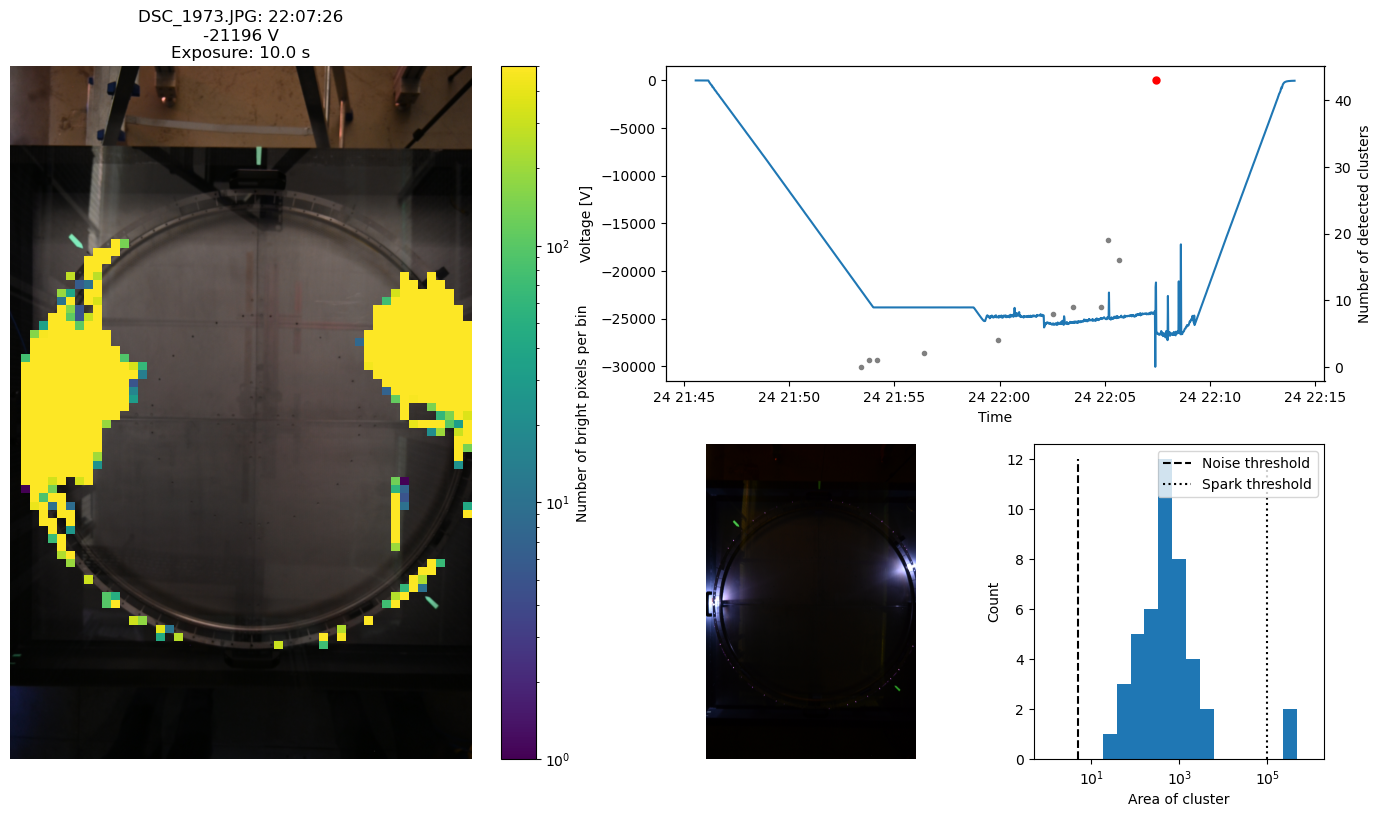

In [8]:
run = campaign.runs[1]
run.load_image_data()
bgd_images = campaign.bright_images[1]
test_id = 10

voltage_times = run.hv_data['time']
voltage = run.hv_data['voltage'].values
img_times = np.array(run.image_data['time'])
img_time_ids = np.searchsorted(voltage_times, img_times)
img_voltages = voltage[img_time_ids]
min_area = 5
area_threshold = 1e5

cluster_pixels = get_cluster_pixels(run.pictures[test_id].get_processed_image(), binary_threshold=30)
rr, cc = cluster_pixels.nonzero()

gs_kw = dict(width_ratios=[2, 1, 1])
fig, ax = plt.subplot_mosaic([['left', 'upper right', 'upper right'],
                              ['left', 'lower center', 'lower right']], figsize=(17, 9), gridspec_kw=gs_kw)
ax['left'].imshow(bgd_images, origin='lower')
hist, xedges, yedges, im = ax['left'].hist2d(cc, rr, bins=50, norm=mpl.colors.LogNorm(vmin=1, vmax=500))
ax['left'].set_xlim(0, bgd_images.shape[1])
ax['left'].set_ylim(0, bgd_images.shape[0])
ax['left'].set_axis_off()
title = f'{run.image_files[test_id].split(os.path.sep)[-1]}: ' + str(img_times[test_id]).split(' ')[-1] + f'\n{img_voltages[test_id] :.0f} V\nExposure: ' + str(run.image_data['exposure'][test_id]) + ' s'
ax['left'].set_title(title)
fig.colorbar(im, ax=ax['left'], label='Number of bright pixels per bin')

ax['upper right'].plot(run.hv_data['time'], run.hv_data['voltage'])
ax['upper right'].set_xlabel('Time')
ax['upper right'].set_ylabel('Voltage [V]')

n_clusters_ax = ax['upper right'].twinx()
n_clusters_ax.plot(run.image_data['time'], run.image_data['n_clusters'], 'o', markersize=3, color='gray')
n_clusters_ax.plot(run.image_data['time'][test_id], run.image_data['n_clusters'][test_id], 'o', markersize=5, color='red')
n_clusters_ax.set_ylabel('Number of detected clusters')

ax['lower center'].imshow(cv2.imread(run.image_files[test_id], cv2.IMREAD_COLOR)[:,:,::-1], origin='lower')
ax['lower center'].set_axis_off()

bins = np.logspace(0, 6, 20)
counts, _, _ = ax['lower right'].hist(run.image_data['areas'][test_id], bins=bins)
maxcount = max(counts)
ax['lower right'].vlines(x=min_area, ymin=0, ymax=maxcount, color='black', linestyle='--', label='Noise threshold')
ax['lower right'].vlines(x=area_threshold, ymin=0, ymax=maxcount, color='black', linestyle=':', label='Spark threshold')
ax['lower right'].set_xscale('log')
ax['lower right'].set_xlabel('Area of cluster')
ax['lower right'].set_ylabel('Count')
ax['lower right'].legend(loc='upper right')
plt.show()